# SETUP

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install ultralytics


import ultralytics
from ultralytics import YOLO

In [ ]:
!pip install supervision
import supervision as sv


In [ ]:
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
import cv2

In [ ]:
!pip install trackers
import trackers

## GOOGLE DRIVE MOUNT

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


# RESTORE DATA

In [ ]:
%cd "/content"
!cp "/content/drive/MyDrive/Colab Notebooks/MVI_1482_VIS.avi" .

!cp "/content/drive/MyDrive/Colab Notebooks/maritime-best.pt" .

!cp "/content/drive/MyDrive/Colab Notebooks/gt.txt" .


/content


In [ ]:
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/MVI_1482_VIS.avi"

In [ ]:
MODEL_PATH = "/content/maritime-best.pt"

# Model Import

In [ ]:
model = YOLO(MODEL_PATH)


In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
print(CLASS_NAMES_DICT)

{0: 'Boat', 1: 'Buoy', 2: 'Ferry', 3: 'Flying bird-plane', 4: 'Kayak', 5: 'Other', 6: 'Sail boat', 7: 'Speed boat', 8: 'Vessel-ship'}


In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names


# class ids matching the class names we have chosen // Ferry only
SELECTED_CLASS_IDS = [2]

# MODEL FRAME TEST

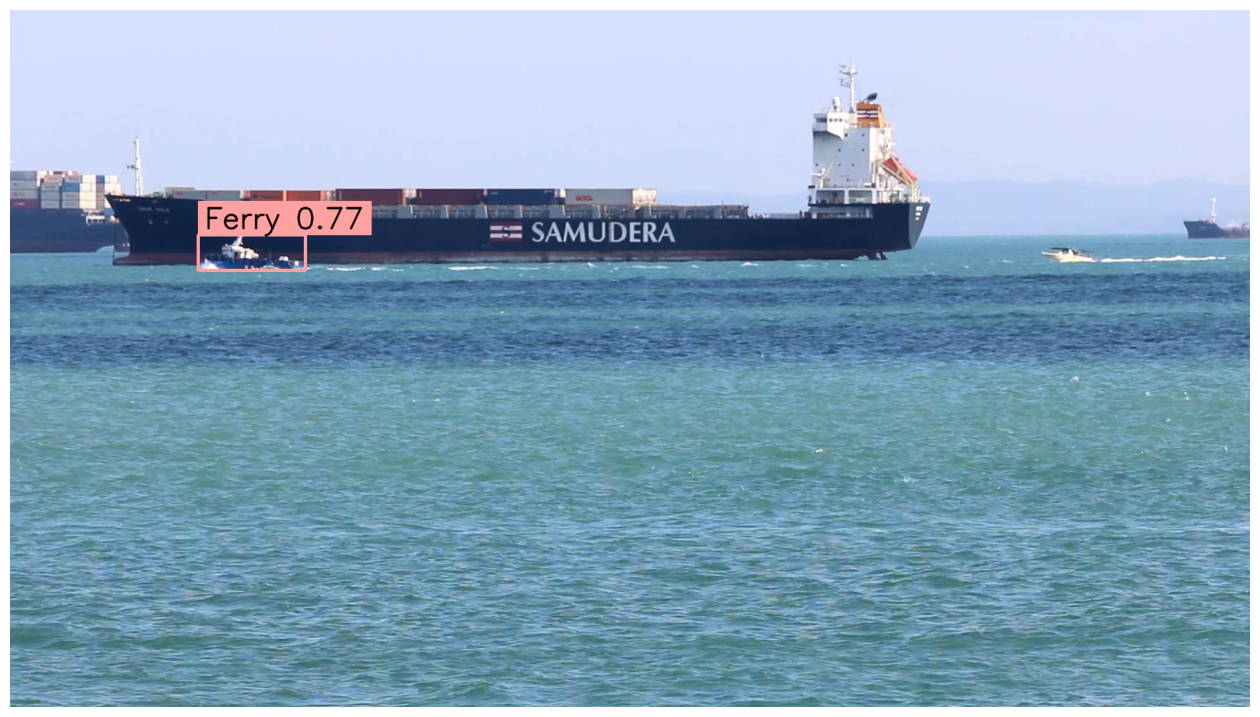

In [ ]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LabelAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

# TRACK

In [ ]:
from trackers import SORTTracker

# SORT Tracking Setup & Evaluation
def process_video_with_sort(video_path, model, output_file, video_output_path):
    # Create SORT tracker instance
    sort_tracker = SORTTracker()

    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    out = cv2.VideoWriter(video_output_path,
                         cv2.VideoWriter_fourcc(*'mp4v'),
                         fps, (width, height))

    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)

    frame_id = 1
    # ID remapping dictionary to start from 1
    id_remap = {}
    next_id = 1

    with open(output_file, 'w') as f:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Get results
            results = model(frame)[0]
            detections = sv.Detections.from_ultralytics(results)

            # Filter selected class (Ferry)
            mask = np.isin(detections.class_id, SELECTED_CLASS_IDS)
            filtered_detections = detections[mask]

            # Filter +0.5 confidence
            conf_mask = filtered_detections.confidence > 0.5
            filtered_detections = filtered_detections[conf_mask]

            # Track only selected class
            tracked_detections = sort_tracker.update(filtered_detections)

            # Process tracks and remap IDs to start from 1
            for i, (bbox, track_id, conf) in enumerate(zip(tracked_detections.xyxy, tracked_detections.tracker_id, tracked_detections.confidence)):
                # Remap ID if needed
                if track_id not in id_remap:
                    id_remap[track_id] = next_id
                    next_id += 1

                mapped_id = id_remap[track_id]
                x1, y1, x2, y2 = bbox
                w = x2 - x1
                h = y2 - y1
                # MOT Challenge format
                f.write(f"{frame_id},{mapped_id},{x1},{y1},{w},{h},{conf},-1,-1,-1\n")

            # For visualization, we'll use the remapped IDs
            remapped_ids = [id_remap[tid] for tid in tracked_detections.tracker_id]

            # Visualize
            labels = [f"#{r_id} Ferry ({conf:.2f})" for r_id, conf
                     in zip(remapped_ids, tracked_detections.confidence)]

            frame = box_annotator.annotate(scene=frame, detections=tracked_detections)
            frame = label_annotator.annotate(scene=frame, detections=tracked_detections, labels=labels)
            out.write(frame)

            frame_id += 1

    cap.release()
    out.release()

    return id_remap

## Run


In [ ]:


# Run SORT tracking
print("Running SORT tracking...")
sort_id_map = process_video_with_sort(
    SOURCE_VIDEO_PATH,
    model,
    'sort_results.txt',
    'sort_tracking_output.mp4'
)




Running SORT tracking...


## Save video outputs to GDrive and Print

In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebooks/sort"
os.makedirs(output_dir, exist_ok=True)

# Save SORT outputs to GDrive
!cp sort_tracking_output.mp4 "/content/drive/MyDrive/Colab Notebooks/sort/"
!cp sort_results.txt "/content/drive/MyDrive/Colab Notebooks/sort/"

# Check SORT results
df_sort = pd.read_csv('sort_results.txt', header=None,
                     names=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z'])

print("\nSORT Stats:")
print(f"Total frame count: {df_sort['frame'].nunique()}")
print(f"Total track count: {df_sort['id'].nunique()}")
print("\nTrack ID counts:")
print(df_sort.groupby('id').size())


SORT Stats:
Total frame count: 454
Total track count: 3

Track ID counts:
id
1      5
2    281
3    338
dtype: int64
